In [5]:
import minGPTLightning
from importlib import reload
reload(minGPTLightning)
from minGPTLightning import CharDataModule, GPTConfig, GPT

# Import pytorch lightning
import pytorch_lightning as pl
pl.seed_everything(hash("setting random seeds 2") % 2**32 - 1)

import wandb
# Use the wandb logger
from pytorch_lightning.loggers import WandbLogger

# login to wandb
wandb.login()
# connect to logging weights and biases, see documentation for more info https://docs.wandb.com/integrations/lightning
wandb_logger = WandbLogger(project="text-template")

wandb.init(project="text-template")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [6]:
# setup data
# 
import random
text_data = CharDataModule(text_path="bncsplitwords.txt", block_size=128, train_weight=100, valid_weight=1, test_weight=1, batch_size=256)
words = list(text_data.text.split())
random.shuffle(words)
print(words[0:100])
text_data.text = text_data.text + "\n\t" # newline and tab at end so character mapping is still same
text_data.prepare_data()
text_data.setup()

# grab samples to log predictions on
samples = next(iter(text_data.val_dataloader()))

['extent', 'and', 'mean', 'How', 'smashed', "Who's", 'up', 'you', 'never', 'ought', 'like', 'can', 'Good', 'cherries', 'The', "I'll", 'where', 'Jean', 'I', 'material', 'minute', 'what', 'get', 'all', 'take', 'might', 'pushes', 'I', 'of', 'but', 'I', 'just', 'but', 'That', 'on', 'up', 'large', 'what', 'but', 'get', 'out', 'Well', 'If', 'i', 'I', 'at', 'the', 'repaired', 'The', 'lo', 'achievement', 'plays', 'it', 'he', 'I', 'your', 'did', 'is', 'Crunch', 'it', 'Geoff', 'have', 'it', 'in', 'He', 'a', 'messing', 'so', 'little', 'last', 'car', 'a', 'okay', 'that', "coffee's", 'he', 'fourteen', "There's", 'that', 'of', "We've", 'is', 'mean', 'when', 'and', 'come', 'baby', 'me', 'easier', 'since', 'virus', 'a', 'got', "couldn't", 'it', 'mind', 'nearly', 'on', 'cross', "that's"]
data has 3094843 characters, 62 unique.


In [7]:
# create the trainer
# TODO: autoscale batch size
from pytorch_lightning.callbacks import ModelCheckpoint
import time
# TODO: learning rate decay
from lr_logger import LearningRateLogger
lr_logger = LearningRateLogger(logging_interval='step')
ckptPath = "ckpts/" + time.strftime('%a_%d_%b_%Y_%H_%M_%S_GMT', time.localtime())
#checkpoint_callback = ModelCheckpoint(monitor='train/loss', dirpath="checkpoints/" + ckptPath, filename='{epoch}', save_last=True, save_top_k=-1)
trainer = pl.Trainer(
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=4,   # set the logging frequency
    gpus=-1,                # use all GPUs
    max_epochs=200,           # number of epochs
    deterministic=True,     # keep it deterministic
    gradient_clip_val=1.0,  # gradient clipping
    callbacks=[lr_logger],
    auto_lr_find=True
    )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:

saved_model = GPT.load_from_checkpoint("ckpts/Thu_17_Dec_2020_14_53_55_GMT/10000.ckpt")
# setup model
mconf = GPTConfig(vocab_size=text_data.vocab_size, block_size=text_data.block_size,
                  n_layer=6, n_head=6, n_embd=512-(512%6), ckpt_path=ckptPath)
model = GPT(mconf, text_data, trainer)
model.load_state_dict(saved_model.state_dict())
initModel = GPT(mconf, text_data, trainer)
oldStateDict = initModel.state_dict()
#model.mconf.print_every = 10

In [9]:
newStateDict = saved_model.state_dict()

# revert any parameters in revertKeys back to initial state (technically this is init params from a different model - it might be good to use the same model? idk)
revertKeys = ['pos_emb']
savedKeys = set(oldStateDict.keys()) - set(revertKeys)
revertDict = dict([(key, oldStateDict[key]) for key in revertKeys] + [(key, newStateDict[key]) for key in savedKeys])
model.load_state_dict(revertDict)





<All keys matched successfully>

In [ ]:
'''
freezeKeys = ['pos_emb']
for param in model.parameters():
    print(param)
    if param in freezeKeys:
        param.requires_grad = False
'''

/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: attribute 'trainer' removed from hparams because it cannot be pickled
  warnings.warn(*args, **kwargs)
/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name    | Type       | Params
---------------------------------------
0 | tok_emb | Embedding  | 31.6 K
1 | drop    | Dropout    | 0     
2 | blocks  | Sequential | 18.8 M
3 | ln_f    | LayerNorm  | 1.0 K 
4 | head    | Linear     | 31.6 K
---------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params


configure optimizers with lr0.0003


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


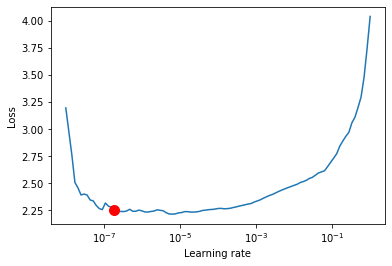

In [5]:
# lr find
lr_finder = trainer.tuner.lr_find(model, train_dataloader=text_data.train_dataloader())
fig = lr_finder.plot(suggest=True)
fig.show()

In [6]:
new_lr = lr_finder.suggestion()
print(new_lr)
model.hparams.lr = new_lr

1.9054607179632475e-07


In [10]:
model.hparams.lr = 1.9054607179632475e-07

In [ ]:

#model.hparams.lr = 1.3245253055572644e-05
print("There will be " + str(len(text_data.train_dataset)) + " training steps")
# fit the model
trainer.fit(model, text_data)



There will be 3034031 training steps



  | Name    | Type       | Params
---------------------------------------
0 | tok_emb | Embedding  | 31.6 K
1 | drop    | Dropout    | 0     
2 | blocks  | Sequential | 18.8 M
3 | ln_f    | LayerNorm  | 1.0 K 
4 | head    | Linear     | 31.6 K
---------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params


configure optimizers with lr1.9054607179632475e-07


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/azureuser/miniconda3/envs/sandbox1/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 0
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 10
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 20
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 30
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 40
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 50
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 60
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 70
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 80
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 90
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 100
{'lr-AdamW/pg1': 7.621842871852994e-08, 'lr-AdamW/pg2': 7.621842871852994e-08} 110
{'lr-AdamW/pg1'

In [10]:
trainer.save_checkpoint("ckpts/Wed_16_Dec_2020_21_34_35_GMT/saved.ckpt")

In [8]:
model = GPT.load_from_checkpoint("checkpoints/Wed_16_Dec_2020_16_41_07_GMT/last.ckpt")

In [21]:
# alright, let's sample some character-level Shakespeare

from minGPTLightning import sample
import torch

sampleModel("hello ", model, 200)

"hello ifarelld foter the t were om\nAn me s\nMmmme ad ast whe ffithat out te t\nI t't thorendin pl yo ware thas y what's\nThe t\nOhacaner t w y's ar wothin avey t'le alaree te\nWer s weraher s m\nYond we te\nYerere"

In [ ]:



# evaluate the model on a test set
trainer.test(datamodule=text_data.test_dataset,
             ckpt_path=None)  # uses last-saved model

# Note: When visiting your run page, it is recommended to use global_step as x-axis to correctly superimpose metrics logged in different stages.
wandb.finish()

Exception: The wandb backend process has shutdown

In [ ]:
_